In [4]:
import sys
sys.path.append('../..')
from lib import model_helper, dataset_generation, automated_evaluation, chat_helper
from anthropic import Anthropic
from lib.automated_evaluation import  caesar_decrypt
from transformers import AutoTokenizer
import pickle
import pandas as pd
from tqdm import tqdm
import torch
token = os.getenv('TOKEN_NAME')
import os
import numpy as np
import re
import json
system_prompt = "You are a helpful, honest and concise assistant."  # Needed for chat model


In [5]:

def average_random_lines(data, N=100):
    """
    This function selects 100 random rows from the input dataset and returns their average.

    Parameters:
    - data (torch.Tensor): The input dataset.

    Returns:
    - torch.Tensor: A tensor containing the average of the randomly selected 100 rows.
    """
    
    # Randomly select 100 indices
    indices = torch.randperm(data.size(0))[:N]
    
    # Select the rows corresponding to these indices
    selected_data = data[indices]
    
    # Return the average of the selected rows
    return torch.mean(selected_data, dim=0)

In [6]:
question_type = "direct_questions"
layer = 15
fiction_path = f"{question_type}/fiction/all_diffs_layer_{layer}.pt"
fiction_activations = torch.load(fiction_path)

truth_path = f"{question_type}/truth/all_diffs_layer_{layer}.pt"
truth_activations = torch.load(truth_path)

mixed_path = f"{question_type}/mixed/all_diffs_layer_{layer}.pt"
mixed_activations = torch.load(mixed_path)



FileNotFoundError: [Errno 2] No such file or directory: 'direct_questions/fiction/all_diffs_layer_15.pt'

In [38]:
mean_fiction_activations = torch.mean(fiction_activations, dim=0)
mean_truth_activations = torch.mean(truth_activations, dim=0)
mean_mixed_activations = torch.mean(mixed_activations, dim=0)
mean_combined_activations = mean_truth_activations + mean_fiction_activations

In [39]:
#print norms
print("Fiction norm: ", np.linalg.norm(mean_fiction_activations))
print("Truth norm: ", np.linalg.norm(mean_truth_activations))
print("Mixed norm: ", np.linalg.norm(mean_mixed_activations))
print("Combined norm: ", np.linalg.norm(mean_combined_activations))

Fiction norm:  10.624983
Truth norm:  10.8585
Mixed norm:  1.9954143
Combined norm:  7.192708


In [33]:
n_lines = [1, 5, 10, 50 ,100, 500]
sampled_activations_fiction = {}
sampled_activations_truth = {}
sampled_activations_mixed = {}
sampled_activations_combined = {}

samples_per_line = 20

for n in n_lines:
    sampled_activations_fiction[n] = []
    sampled_activations_truth[n] = []
    sampled_activations_mixed[n] = []
    sampled_activations_combined[n] = []
    
    for i in range(samples_per_line):
        sampled_activations_fiction[n].append(average_random_lines(fiction_activations, N=n))
        sampled_activations_truth[n].append(average_random_lines(truth_activations, N=n))
        sampled_activations_mixed[n].append(average_random_lines(mixed_activations, N=n))
        sampled_activations_combined[n].append(average_random_lines(truth_activations + fiction_activations, N=n))

In [34]:
distances_fiction = {}
distances_truth = {}
distances_mixed = {}
distances_combined = {}

for n in n_lines:
    distances_fiction[n] = []
    distances_truth[n] = []
    distances_mixed[n] = []
    distances_combined[n] = []
    
    for i in range(samples_per_line):
        distances_fiction[n].append(np.linalg.norm(sampled_activations_fiction[n][i] - mean_fiction_activations))
        distances_truth[n].append(np.linalg.norm(sampled_activations_truth[n][i] - mean_truth_activations))
        distances_mixed[n].append(np.linalg.norm(sampled_activations_mixed[n][i] - mean_mixed_activations))
        distances_combined[n].append(np.linalg.norm(sampled_activations_combined[n][i] - mean_combined_activations))

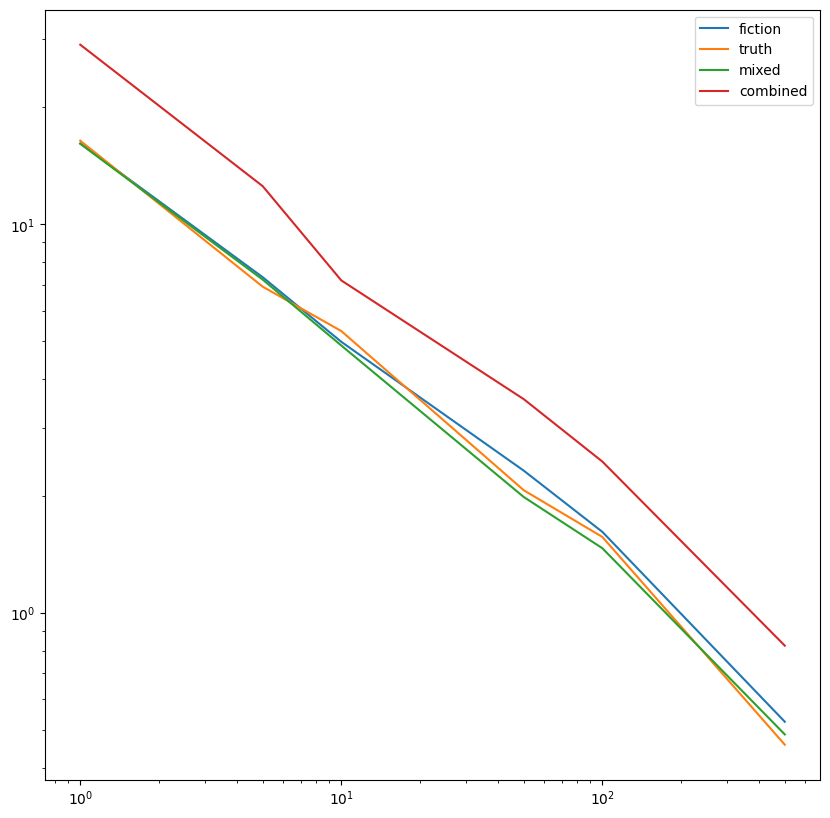

In [35]:
#plot the differences dependent on n 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(n_lines, [np.mean(distances_fiction[n]) for n in n_lines], label="fiction")
plt.plot(n_lines, [np.mean(distances_truth[n]) for n in n_lines], label="truth")
plt.plot(n_lines, [np.mean(distances_mixed[n]) for n in n_lines], label="mixed")
plt.plot(n_lines, [np.mean(distances_combined[n]) for n in n_lines], label="combined")
plt.yscale('log')
plt.xscale('log')
plt.legend()
